In [14]:
import sys
from os.path import join
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion.utils.misc import read_config, set_random_seed, \
    init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import visualize_prompts, PixArtAlphaPipeline_custom, \
    load_embed_and_mask, visualize_prompts_with_traj
from utils.pixart_utils import construct_diffuser_pipeline_from_config, construct_pixart_transformer_from_config, state_dict_convert

### Systematic storing attention maps across time steps

In [25]:
import math
import torch
from typing import Optional
import torch.nn.functional as F
from einops import rearrange
from diffusers.models.attention_processor import Attention

def scaled_dot_product_attention(
    query, key, value, attn_mask=None, dropout_p=0.0, is_causal=False, scale=None
) -> torch.Tensor:
    B, H, L, D = query.shape
    _, _, S, _ = key.shape

    scale_factor = 1 / math.sqrt(D) if scale is None else scale

    # Compute attention scores
    attn_weight = torch.matmul(query, key.transpose(-2, -1)) * scale_factor

    # Apply causal mask if needed
    if is_causal:
        causal_mask = torch.triu(
            torch.ones(L, S, dtype=torch.bool, device=query.device), diagonal=1
        )
        attn_weight = attn_weight.masked_fill(causal_mask.unsqueeze(0).unsqueeze(0), float("-inf"))

    # Apply attention mask if provided
    if attn_mask is not None:
        attn_mask = attn_mask.to(query.device)
        if attn_mask.dtype == torch.bool:
            attn_weight = attn_weight.masked_fill(~attn_mask, float("-inf"))
        else:
            attn_weight = attn_weight + attn_mask

    # Compute the attention probabilities
    attn_weight = torch.softmax(attn_weight, dim=-1)

    # Apply dropout if specified
    attn_weight = F.dropout(attn_weight, p=dropout_p, training=True)

    # Compute the final attention output
    attn_output = torch.matmul(attn_weight, value)

    return attn_output, attn_weight


In [26]:
class AttnProcessor2_0_Store:
    r"""
    Processor for implementing scaled dot-product attention (enabled by default if you're using PyTorch 2.0).
    """

    def __init__(self):
        if not hasattr(F, "scaled_dot_product_attention"):
            raise ImportError("AttnProcessor2_0 requires PyTorch 2.0, to use it, please upgrade PyTorch to 2.0.")

    def __call__(
        self,
        attn: Attention,
        hidden_states: torch.Tensor,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        temb: Optional[torch.Tensor] = None,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            # deprecate("scale", "1.0.0", deprecation_message)

        residual = hidden_states
        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )

        if attention_mask is not None:
            attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
            # scaled_dot_product_attention expects attention_mask shape to be
            # (batch, heads, source_length, target_length)
            attention_mask = attention_mask.view(batch_size, attn.heads, -1, attention_mask.shape[-1])

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        inner_dim = key.shape[-1]
        head_dim = inner_dim // attn.heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        if attn.norm_q is not None:
            query = attn.norm_q(query)
        if attn.norm_k is not None:
            key = attn.norm_k(key)

        # the output of sdp = (batch, num_heads, seq_len, head_dim)
        # TODO: add support for attn.scale when we move to Torch 2.1
        # hidden_states = F.scaled_dot_product_attention(
        #     query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
        # )
        hidden_states, attention_probs = scaled_dot_product_attention(
            query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
        )
        self.attn_map = attention_probs

        hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim)
        hidden_states = hidden_states.to(query.dtype)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

In [7]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, List, Tuple

class PixArtAttentionVisualizer_Store:
    def __init__(self, pipe):
        self.pipe = pipe
        self.activation = defaultdict(list)
        self.hook_handles = []

    def clear_activation(self):
        self.activation = defaultdict(list)
    
    def hook_forger(self, key: str):
        """Create a hook to capture attention patterns"""
        def hook(module, input, output):
            self.activation[key].append(module.processor.attn_map.detach().cpu())
        return hook

    def hook_transformer_attention(self, module, module_id: str):
        """Hook both self-attention and cross-attention modules in PixArt"""
        hooks = []
        # For self-attention (attn1)
        if hasattr(module, 'attn1'):
            h1 = module.attn1.register_forward_hook(self.hook_forger(f"{module_id}_self_attn_map"))
            hooks.extend([h1])

        # For cross-attention (attn2)
        if hasattr(module, 'attn2'):
            h3 = module.attn2.register_forward_hook(self.hook_forger(f"{module_id}_cross_attn_map"))
            hooks.extend([h3])

        return hooks

    def setup_hooks(self):
        """Set up hooks for all transformer blocks"""
        print("Setting up hooks for PixArt attention modules:")

        for block_idx, block in enumerate(self.pipe.transformer.transformer_blocks):
            print(f"- Block {block_idx}")
            hooks = self.hook_transformer_attention(block, f"block{block_idx:02d}")
            self.hook_handles.extend(hooks)

    def cleanup_hooks(self):
        """Remove all hooks"""
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = []

In [27]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"
ckptdir = join(savedir, "checkpoints")
config = read_config(join(savedir, 'config.py'))
weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
pipeline = construct_diffuser_pipeline_from_config(config, pipeline_class=PixArtAlphaPipeline_custom)
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

<All keys matched successfully>

In [28]:
for layer in pipeline.transformer.transformer_blocks:
    
    layer.attn1.processor = AttnProcessor2_0_Store()
    layer.attn2.processor = AttnProcessor2_0_Store()
    layer.attn1.processor.store_attn_map = True
    layer.attn2.processor.store_attn_map = True
    # layer.attn1.processor.__call__ = attn_call2_0
    # layer.attn2.processor.__call__ = attn_call2_0
# pipeline.transformer.transformer_blocks[0].attn1.store_attn_map

In [29]:
from transformers import T5Tokenizer, T5EncoderModel

T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")

In [30]:
attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
attnvis_store.setup_hooks()

Setting up hooks for PixArt attention modules:
- Block 0
- Block 1
- Block 2
- Block 3
- Block 4
- Block 5
- Block 6
- Block 7
- Block 8
- Block 9
- Block 10
- Block 11


In [31]:
validation_prompts = config.validation_prompts
prompt_cache_dir = config.prompt_cache_dir

In [46]:
attnvis_store.clear_activation()
image_logs_sel, latents_traj_sel, pred_traj_sel, t_traj_sel = visualize_prompts_with_traj(\
    pipeline, validation_prompts[5:6], prompt_cache_dir, config.model_max_length, weight_dtype)

embed_infos = load_embed_and_mask(validation_prompts[5:6], prompt_cache_dir, config.model_max_length, device="cuda")

print(embed_infos[0]['prompt'])
prompt = embed_infos[0]['prompt']
# attention_mask_raw = embed_infos[0]['emb_mask'].cpu()
token_ids = tokenizer.encode(prompt)
word_tokens = tokenizer.convert_ids_to_tokens(token_ids)
word_tokens = [token.replace("▁", "") for token in word_tokens]

torch.Size([50, 20, 4096])
torch.Size([50, 20])
triangle is to the left of triangle


In [47]:
layer_i = 11 # note the 
timestep = -1
self_attn_map = attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'][timestep]
cross_attn_map = attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'][timestep]
print(self_attn_map.shape, cross_attn_map.shape)

torch.Size([50, 12, 64, 64]) torch.Size([50, 12, 64, 20])


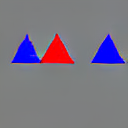

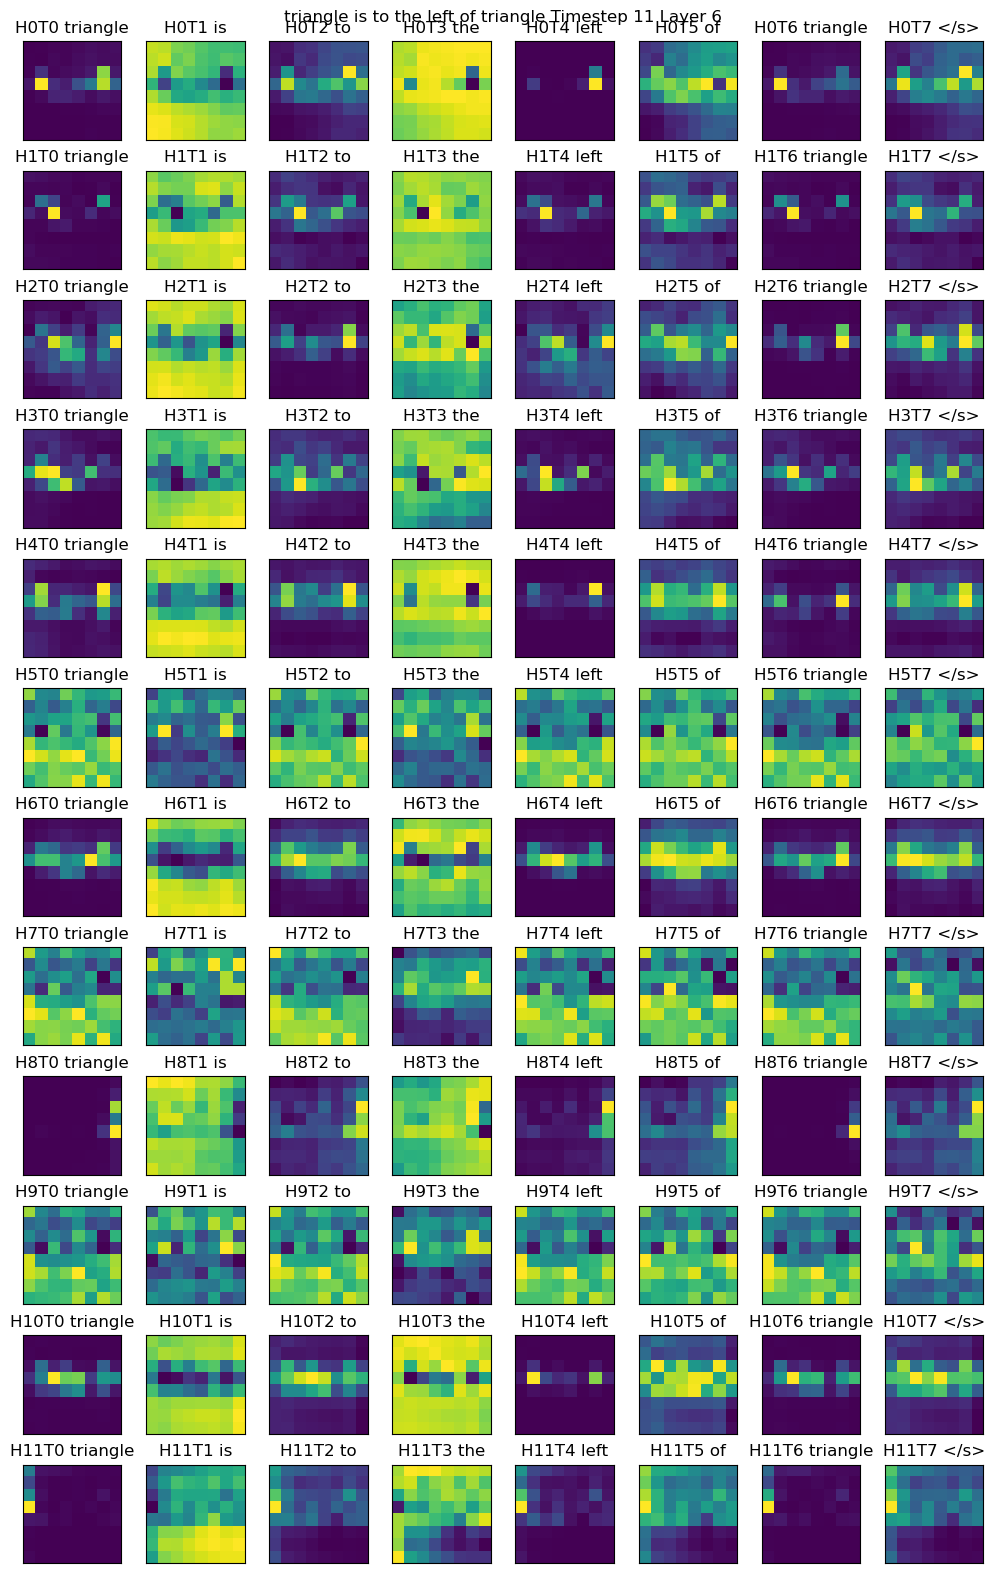

In [48]:
layer_i = 6 # note the 
timestep = 11
self_attn_map = attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'][timestep]
cross_attn_map = attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'][timestep]
sample_id = 15
display(image_logs_sel[0]['images'][sample_id])
figh, axs = plt.subplots(12, len(word_tokens), figsize=(10, 16))
for head_id in range(12):
    for token_id in range(len(word_tokens)):
        ax = axs[head_id, token_id]
        ax.imshow(cross_attn_map[25 + sample_id, 
                                 head_id, :, 
                                 token_id].view(8, 8).cpu().numpy())
        ax.axis('image')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(f'H{head_id}T{token_id} {word_tokens[token_id]}')
        
plt.suptitle(f'{prompt} Timestep {timestep} Layer {layer_i}')
plt.tight_layout()


### Visualize cross attention matrix 

In [87]:
prompt_slice = slice(0, 1)
attnvis_store.clear_activation()
image_logs_sel, latents_traj_sel, pred_traj_sel, t_traj_sel = visualize_prompts_with_traj(\
    pipeline, validation_prompts[prompt_slice], prompt_cache_dir, config.model_max_length, weight_dtype, random_seed=0)

embed_infos = load_embed_and_mask(validation_prompts[prompt_slice], prompt_cache_dir, config.model_max_length, device="cuda")
print(embed_infos[0]['prompt'])
prompt = embed_infos[0]['prompt']
# attention_mask_raw = embed_infos[0]['emb_mask'].cpu()
token_ids = tokenizer.encode(prompt)
word_tokens = tokenizer.convert_ids_to_tokens(token_ids)
word_tokens = [token.replace("▁", "") for token in word_tokens]
print(word_tokens)

torch.Size([50, 20, 4096])
torch.Size([50, 20])
triangle is to the upper left of square
['triangle', 'is', 'to', 'the', 'upper', 'left', 'of', 'square', '</s>']


In [88]:
layer_i = 11 # note the 
timestep = 1
self_attn_map = attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'][timestep]
cross_attn_map = attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'][timestep]
print(self_attn_map.shape, cross_attn_map.shape)

torch.Size([50, 12, 64, 64]) torch.Size([50, 12, 64, 20])


In [89]:
word_tokens

['triangle', 'is', 'to', 'the', 'upper', 'left', 'of', 'square', '</s>']

#### High attention to "meaningless" tokens

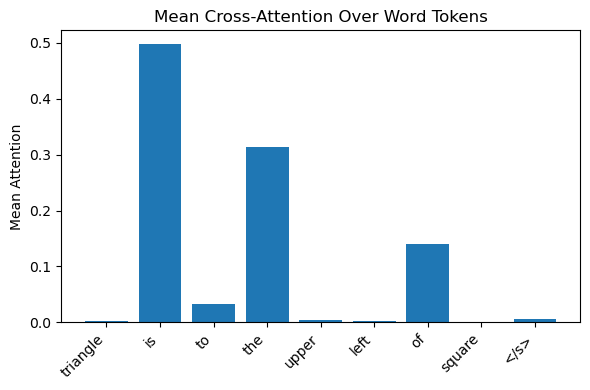

In [90]:

layer_i = 11 # note the 
timestep = 11
self_attn_map = attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'][timestep]
cross_attn_map = attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'][timestep]

plt.figure(figsize=(6, 4))
attn_means = cross_attn_map[25:, :, :, :].mean(dim=(0, 1, 2))
plt.bar(range(len(word_tokens)), attn_means[:len(word_tokens)])
plt.xticks(range(len(word_tokens)), word_tokens, rotation=45, ha='right')
plt.ylabel('Mean Attention')
plt.title('Mean Cross-Attention Over Word Tokens')
plt.tight_layout()
plt.show()

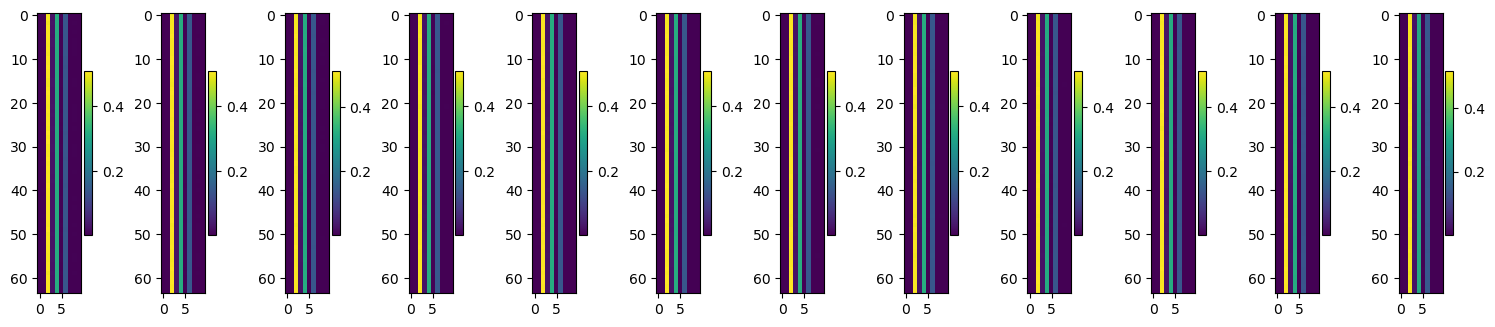

In [73]:
prompt_token_mask = embed_infos[0]['emb_mask'].cpu().squeeze(0).bool()
sample_id = 1
layer_i = 0 # note the 
timestep = 1
self_attn_map = attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'][timestep]
cross_attn_map = attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'][timestep]
plt.figure(figsize=(15, 5))
for head_id in range(12): 
    plt.subplot(1, 12, head_id + 1)
    plt.imshow(cross_attn_map[25 + sample_id, head_id, :, prompt_token_mask].cpu().numpy())
    # plt.imshow(cross_attn_map[sample_id, head_id :, :].cpu().numpy())
    plt.colorbar()
    # plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
layer_i = 6 # note the 
timestep = 11
self_attn_map = attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'][timestep]
cross_attn_map = attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'][timestep]
sample_id = 15
display(image_logs_sel[0]['images'][sample_id])
figh, axs = plt.subplots(12, len(word_tokens), figsize=(10, 16))
for head_id in range(12):
    for token_id in range(len(word_tokens)):
        ax = axs[head_id, token_id]
        ax.imshow(cross_attn_map[25 + sample_id, 
                                 head_id, :, 
                                 token_id].view(8, 8).cpu().numpy())
        ax.axis('image')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(f'H{head_id}T{token_id} {word_tokens[token_id]}')
        
plt.suptitle(f'{prompt} Timestep {timestep} Layer {layer_i}')
plt.tight_layout()

In [ ]:
prompt_token_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [92]:
import torch as th
from utils.custom_text_encoding_utils import save_prompt_embeddings_randemb, RandomEmbeddingEncoder, RandomEmbeddingEncoder_wPosEmb

In [ ]:
text_feat_dir = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndemb/caption_feature_wmask'

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(T5_path)
rnd_encoding = th.load(join(text_feat_dir, "word_embedding_dict.pt"))
rndpos_encoder = RandomEmbeddingEncoder_wPosEmb(rnd_encoding["embedding_dict"], 
                                              rnd_encoding["input_ids2dict_ids"], 
                                              rnd_encoding["dict_ids2input_ids"], 
                                              max_seq_len=20, embed_dim=4096,
                                              wpe_scale=1/6).to("cuda")